### This notebook shows how to generate an RMF EoS and solve the tov equations 

You will need axionmlk.py and tovmlk.py from this repo as well as numpy and scipy.  If you want to use a tabulated crust eos, those can be found in eosmlk.py

In [27]:
#import libraries
from src.tovmlk import tov_solver
from src.axionmlk import iufsu_star
from src.eosmlk import bps_energy_density, bps_pressure

from numpy import linspace, logspace, sqrt as np_sqrt, sin as np_sin
from math import pi, log10
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

from csv import writer, reader

import matplotlib.pyplot as plt

#makes plots bigger and use Latex fonts
from matplotlib import rcParams
rcParams["figure.dpi"]=600
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size'] = 14
rcParams['lines.linewidth'] = 2.5

In [7]:
#all quantities are in units of fm

HBARC = 197.3
NEUTRON_MASS = 939.57 / HBARC
PROTON_MASS = 938.27 / HBARC
NUCLEON_MASS = (NEUTRON_MASS + PROTON_MASS) / 2
MUON_MASS = 105.7 / HBARC
ELECTRON_MASS = 0.511 / HBARC
F_PION = 92.4 / HBARC 
PION_MASS = 138.04 / HBARC
UP_MASS = 2.2 / HBARC
DOWN_MASS = 4.7 / HBARC
FTHETA_MIN = (DOWN_MASS - UP_MASS) / (DOWN_MASS + UP_MASS)

MEVFM3_TO_GCM3 = 1.78e12
FM4_TO_DYNECM2 = 3.16e35

def density(kf): return kf**3 / (3 * pi**2)
def closest_ix(val, list_of_vals): return list(list_of_vals).index(min(list_of_vals, key = lambda x: abs(val - x)))
def ftheta_func(theta): return np_sqrt(1 - 4 * UP_MASS * DOWN_MASS / (UP_MASS + DOWN_MASS)**2 * np_sin(theta / 2)**2)

## All the data found in this block is stored in csvs that can be imported

In [ ]:
#calculate the eos for a large range of mub 
#for the values of Ksig in the paper, below you can see the necessary ranges for each part of the crust where the full Gibbs equality is achieved

sig_pin = 50 / 197.3
delta_sigma = 1 / 197.3

#this surface tension is chosen to match the iufsu_star neutron drip to the neutron drip pressure in the bps equation of state
st = 0.75 / 197.3

mue_outer_norm = ELECTRON_MASS + logspace(-6, log10(0.0102 - ELECTRON_MASS), 1000)
mub_outer_norm = NUCLEON_MASS + 1 / 197.3 * (-9.001 + logspace(-3, log10((NEUTRON_MASS - NUCLEON_MASS) * 197.3 + 9.001), 1000))
mub_inner_norm = linspace(NEUTRON_MASS + 0.001 / 197.3, NUCLEON_MASS + 9.845 / 197.3, 1000)
mub_core_norm = [NUCLEON_MASS + 10.14 / 197.3 - 0.01 + elt for elt in logspace(-2, log10(3), 10**4)]

#for the outermost part of the crust where finite size effects will be ignored
mue_outer_ax0 = ELECTRON_MASS + logspace(-6, log10(0.0197 - ELECTRON_MASS), 1000)
mue_outer_ax1 = ELECTRON_MASS + logspace(-6, log10(0.145 - ELECTRON_MASS), 1000)
mue_outer_ax2 = ELECTRON_MASS + logspace(-6, log10(0.298 - ELECTRON_MASS), 1000)
mue_outer_ax4 = ELECTRON_MASS + logspace(-6, log10(0.0648 - ELECTRON_MASS), 1000)

#for the rest of the outer crust where size effects will be included
mub_outer_ax0 = NUCLEON_MASS + 1 / 197.3 * (-38.001 + logspace(-3, log10(38.001 - 29.46), 1000))
mub_outer_ax1 = NUCLEON_MASS + 1 / 197.3 * (-38.001 + logspace(-3, log10(38.001 - 29.46), 1000))
mub_outer_ax2 = NUCLEON_MASS + 1 / 197.3 * (-38.001 + logspace(-3, log10(38.001 - 35.55), 1000))
mub_outer_ax4 = NUCLEON_MASS + 1 / 197.3 * (-77.001 + logspace(-3, log10(77.001 - 53.523), 1000))

#when the nuclear force is modified there is no inner crust
mub_inner_ax0 = linspace(NUCLEON_MASS - 29.45 / 197.3, NUCLEON_MASS - 20.15 / 197.3, 1000)

mub_core_ax0 = [NUCLEON_MASS - 19.85 / 197.3 - 0.01 + elt for elt in logspace(-2, log10(3.1), 10**4)]
mub_core_ax1 = [NUCLEON_MASS - 25.91 / 197.3 - 0.01 + elt for elt in logspace(-2, log10(3.1), 10**4)]
mub_core_ax2 = [NUCLEON_MASS - 32.53 / 197.3 - 0.01 + elt for elt in logspace(-2, log10(3), 10**4)]
mub_core_ax4 = [NUCLEON_MASS - 51.096 / 197.3 - 0.01 + elt for elt in logspace(-2, log10(3), 10**4)]

p_norm_raw = []
ed_norm_raw = []
mub_norm = []
nb_norm = []
mue_norm = []

p_ax0 = []
ed_ax0 = []
mub_ax0 = []
nb_ax0 = []
mue_ax0 = []

p_ax2 = []
ed_ax2 = []
mub_ax2 = []
nb_ax2 = []
mue_ax2 = []

p_ax4 = []
ed_ax4 = []
mub_ax4 = []
nb_ax4 = []
mue_ax4 = []

constants = iufsu_star(sig_pin, delta_sigma, 0, 0, 0, 0)
for mue in mue_outer_norm:
    results_temp = constants.eos_data_outer_crust(mue, ftheta = 1)
    p_norm_raw.append(results_temp[5])
    ed_norm_raw.append(results_temp[4])
    mub_norm.append(results_temp[3] + 5.966 / 197.3)
    nb_norm.append((density(results_temp[0]) + density(results_temp[1])) * results_temp[6])
    mue_norm.append(mue)

for mub in mub_outer_norm:
    results_temp = constants.eos_data_outer_crust_finite_size(mub, ftheta_val = 1, surf_tension = st)
    p_norm_raw.append(results_temp[4])
    ed_norm_raw.append(results_temp[3])
    mub_norm.append(mub)
    nb_norm.append((density(results_temp[0]) + density(results_temp[1])) * results_temp[5])
    mue_norm.append(results_temp[2])

for mub in mub_inner_norm:
    results_temp = constants.eos_data_inner_crust_finite_size(mub, ftheta_val = 1, surf_tension = st, d = 3)
    p_norm_raw.append(results_temp[5])
    ed_norm_raw.append(results_temp[4])
    mub_norm.append(mub)
    nb_norm.append((density(results_temp[0]) + density(results_temp[1])) * results_temp[6] + density(results_temp[2]) * (1 - results_temp[6]))
    mue_norm.append(results_temp[3])

for mub in mub_core_norm:
    if mub < 6.6:
        results_temp = constants.eos_data(mub, ftheta_val = 1)
    elif mub < 7.24:
        results_temp = constants.eos_data(mub, ftheta_val = 1, nuc_guess = (0.2, 0.2, -0.05, 1.3, 2.5, 1.2))
    else:
        results_temp = constants.eos_data(mub, ftheta_val = 1, nuc_guess = (0.2, 0.2, -0.05, 1.8, 3, 1.8))
    p_norm_raw.append(results_temp[4])
    ed_norm_raw.append(results_temp[3])
    mub_norm.append(mub)
    nb_norm.append(density(results_temp[0]) + density(results_temp[1]))
    mue_norm.append(results_temp[2])

for mue in mue_outer_ax0:
    results_temp = constants.eos_data_outer_crust(mue, ftheta = FTHETA_MIN)
    p_ax0.append(results_temp[5])
    ed_ax0.append(results_temp[4])
    mub_ax0.append(results_temp[3])
    nb_ax0.append((density(results_temp[0]) + density(results_temp[1])) * results_temp[6])
    mue_ax0.append(mue)

for mub in mub_outer_ax0:
    results_temp = constants.eos_data_outer_crust_finite_size(mub, ftheta_val = FTHETA_MIN, surf_tension = st)
    p_ax0.append(results_temp[4])
    ed_ax0.append(results_temp[3])
    mub_ax0.append(mub)
    nb_ax0.append((density(results_temp[0]) + density(results_temp[1])) * results_temp[5])
    mue_ax0.append(results_temp[2])

for mub in mub_inner_ax0:
    results_temp = constants.eos_data_inner_crust_finite_size(mub, ftheta_val = FTHETA_MIN, surf_tension = st, d = 3,
        nuc_guess_prot_axion = (0.3, 0.2, -0.01, 1.2, 1.4))
    p_ax0.append(results_temp[5])
    ed_ax0.append(results_temp[4])
    mub_ax0.append(mub)
    nb_ax0.append((density(results_temp[0]) + density(results_temp[1])) * results_temp[6] + density(results_temp[2]) * (1 - results_temp[6]))
    mue_ax0.append(results_temp[3])

for mub in mub_core_ax0:
    if mub < 6.7:
        results_temp = constants.eos_data(mub, ftheta_val = FTHETA_MIN)
    elif mub < 7.24:
        results_temp = constants.eos_data(mub, ftheta_val = FTHETA_MIN, nuc_guess = (0.2, 0.2, -0.05, 1.3, 2.5, 1.2))
    else:
        results_temp = constants.eos_data(mub, ftheta_val = FTHETA_MIN, nuc_guess = (0.2, 0.2, -0.05, 1.8, 3, 1.8))
    p_ax0.append(results_temp[4])
    ed_ax0.append(results_temp[3])
    mub_ax0.append(mub)
    nb_ax0.append(density(results_temp[0]) + density(results_temp[1]))
    mue_ax0.append(results_temp[2])

constants = iufsu_star(sig_pin, delta_sigma, 0, 0.2, 0, 0)
for mue in mue_outer_ax2:
    results_temp = constants.eos_data_outer_crust(mue, ftheta = FTHETA_MIN)
    p_ax2.append(results_temp[5])
    ed_ax2.append(results_temp[4])
    mub_ax2.append(results_temp[3])
    nb_ax2.append((density(results_temp[0]) + density(results_temp[1])) * results_temp[6])
    mue_ax2.append(mue)

for mub in mub_outer_ax2:
    results_temp = constants.eos_data_outer_crust_finite_size(mub, ftheta_val = FTHETA_MIN, surf_tension = st)
    p_ax2.append(results_temp[4])
    ed_ax2.append(results_temp[3])
    mub_ax2.append(mub)
    nb_ax2.append((density(results_temp[0]) + density(results_temp[1])) * results_temp[5])
    mue_ax2.append(results_temp[2])

for mub in mub_core_ax2:
    if mub < 6.5:
        results_temp = constants.eos_data(mub, ftheta_val = FTHETA_MIN)
    elif mub < 6.89:
        results_temp = constants.eos_data(mub, ftheta_val = FTHETA_MIN, nuc_guess = (0.2, 0.2, -0.05, 1.3, 2.5, 1.2))
    else:
        results_temp = constants.eos_data(mub, ftheta_val = FTHETA_MIN, nuc_guess = (0.2, 0.2, -0.05, 1.8, 3, 1.8))
    p_ax2.append(results_temp[4])
    ed_ax2.append(results_temp[3])
    mub_ax2.append(mub)
    nb_ax2.append(density(results_temp[0]) + density(results_temp[1]))
    mue_ax2.append(results_temp[2])

constants = iufsu_star(sig_pin, delta_sigma, 0, 0.47, 0, 0)
for mue in mue_outer_ax4:
    results_temp = constants.eos_data_outer_crust(mue, ftheta = FTHETA_MIN)
    p_ax4.append(results_temp[5])
    ed_ax4.append(results_temp[4])
    mub_ax4.append(results_temp[3])
    nb_ax4.append((density(results_temp[0]) + density(results_temp[1])) * results_temp[6])
    mue_ax4.append(mue)

for mub in mub_outer_ax4:
    results_temp = constants.eos_data_outer_crust_finite_size(mub, ftheta_val = FTHETA_MIN, surf_tension = st)
    p_ax4.append(results_temp[4])
    ed_ax4.append(results_temp[3])
    mub_ax4.append(mub)
    nb_ax4.append((density(results_temp[0]) + density(results_temp[1])) * results_temp[5])
    mue_ax4.append(results_temp[2])

for mub in mub_core_ax4:
    if mub < 6.3:
        results_temp = constants.eos_data(mub, ftheta_val = FTHETA_MIN, nuc_guess = (0.4, 0.2, -0.01, 0.8, 2, 0.8))
    else:
        results_temp = constants.eos_data(mub, ftheta_val = FTHETA_MIN, nuc_guess = (0.4, 0.2, -0.05, 1.5, 2.5, 1.5))
    p_ax4.append(results_temp[4])
    ed_ax4.append(results_temp[3])
    mub_ax4.append(mub)
    nb_ax4.append(density(results_temp[0]) + density(results_temp[1]))
    mue_ax4.append(results_temp[2])

c:\Users\Kumamoto\git code\axionns-public\src\axionmlk.py:460: RuntimeWarning: divide by zero encountered in double_scalars
  nucleus_vol_frac = 1 / (1 - prot_charge / no_prot_charge)


2.5370330836160804e-16
-1.205632815803881e-16
-1.218643241873707e-16
-2.224782857940255e-16
-8.803721640582296e-17
2.389581588158052e-16
-6.591949208711867e-17
-2.467644144577008e-16
-1.43982048506075e-16
-1.5612511283791264e-17
4.0332320816460765e-17
3.729655473350135e-17
6.678685382510707e-17
-8.803721640582296e-17
-7.762887554996212e-17
-4.8138576458356397e-17
1.3010426069826053e-16
1.2880321809127793e-16
1.8474805019152996e-16
-7.979727989493313e-17
-1.5655879370690684e-16
2.905661822261152e-17
-7.849623728795052e-17
3.0010716134398763e-16
4.640385298237959e-17
2.411265631607762e-16
3.5214886562329184e-16
-5.984795992119984e-17
7.112366251504909e-17
-3.3393426912553537e-17
-1.3747683547116196e-16
-1.2750217548429532e-16
1.9949319973733282e-17
1.9905951886833861e-16
-2.1684043449710089e-16
9.627715291671279e-17
-1.6176296413483726e-16
-8.673617379884035e-19
-3.8163916471489756e-17
-1.3400738851920835e-16
-1.5612511283791264e-17
-1.3574211199518516e-16
1.1796119636642288e-16
1.665334

If you are ever using the finite size code and it doesn't print a number that is less than about $10^{-15}$ it failed to find a stable size and you need to look at if you gave it a chemical potential where there is no solution for that phase or if you are in the very outermost part of the crust where the nuclei are small enough that the bulk approximation used in the finite size code has failed.  In the latter case, it either better to not use the finite size code at all or to use the liquid drop model

## This shows how the data was written and is only here if you want to copy it, don't run this unless you want to delete the data that is already in the folder!

In [ ]:
"""
# Combine data row-wise
rows = zip(mub_norm, nb_norm, ed_norm_raw, p_norm_raw, mue_norm)
# Write to CSV
with open("normal.csv", mode="w", newline="") as file:
    writer_temp = writer(file)
    writer_temp.writerow(["muB", "nB", "energy", "pressure", "mue"])  # header
    writer_temp.writerows(rows)

# Combine data row-wise
rows = zip(mub_ax0, nb_ax0, ed_ax0, p_ax0, mue_ax0)
# Write to CSV
with open("axion_0.csv", mode="w", newline="") as file:
    writer_temp = writer(file)
    writer_temp.writerow(["muB", "nB", "energy", "pressure", "mue"])  # header
    writer_temp.writerows(rows)

# Combine data row-wise
rows = zip(mub_ax2, nb_ax2, ed_ax2, p_ax2, mue_ax2)
# Write to CSV
with open("axion_2.csv", mode="w", newline="") as file:
    writer_temp = writer(file)
    writer_temp.writerow(["muB", "nB", "energy", "pressure", "mue"])  # header
    writer_temp.writerows(rows)

# Combine data row-wise
rows = zip(mub_ax4, nb_ax4, ed_ax4, p_ax4, mue_ax4)
# Write to CSV
with open("axion_4.csv", mode="w", newline="") as file:
    writer_temp = writer(file)
    writer_temp.writerow(["muB", "nB", "energy", "pressure", "mue"])  # header
    writer_temp.writerows(rows)
"""

## This reads in the csv data if you don't want to calculate it yourself

In [31]:
p_norm_raw = []
ed_norm_raw = []
mub_norm = []
nb_norm = []
mue_norm = []

p_ax0 = []
ed_ax0 = []
mub_ax0 = []
nb_ax0 = []
mue_ax0 = []

p_ax2 = []
ed_ax2 = []
mub_ax2 = []
nb_ax2 = []
mue_ax2 = []

p_ax4 = []
ed_ax4 = []
mub_ax4 = []
nb_ax4 = []
mue_ax4 = []

with open('RMF data/normal.csv', "r", newline="") as f:
    reader_temp = reader(f)
    next(reader_temp)  # skip header row
    for row in reader_temp:
        mub_norm.append(float(row[0]))
        nb_norm.append(float(row[1]))
        ed_norm_raw.append(float(row[2]))
        p_norm_raw.append(float(row[3]))
        mue_norm.append(float(row[4]))

with open('RMF data/axion_0.csv', "r", newline="") as f:
    reader_temp = reader(f)
    next(reader_temp)  # skip header row
    for row in reader_temp:
        mub_ax0.append(float(row[0]))
        nb_ax0.append(float(row[1]))
        ed_ax0.append(float(row[2]))
        p_ax0.append(float(row[3]))
        mue_ax0.append(float(row[4]))

with open('RMF data/axion_2.csv', "r", newline="") as f:
    reader_temp = reader(f)
    next(reader_temp)  # skip header row
    for row in reader_temp:
        mub_ax2.append(float(row[0]))
        nb_ax2.append(float(row[1]))
        ed_ax2.append(float(row[2]))
        p_ax2.append(float(row[3]))
        mue_ax2.append(float(row[4]))

with open('RMF data/axion_4.csv', "r", newline="") as f:
    reader_temp = reader(f)
    next(reader_temp)  # skip header row
    for row in reader_temp:
        mub_ax4.append(float(row[0]))
        nb_ax4.append(float(row[1]))
        ed_ax4.append(float(row[2]))
        p_ax4.append(float(row[3]))
        mue_ax4.append(float(row[4]))

<ipython-input-32-16c5492dd113>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_temp.set_xticklabels([' ', ' ', '$10^{12}$', '$10^{13}$', '$10^{14}$', '$10^{15}$'])


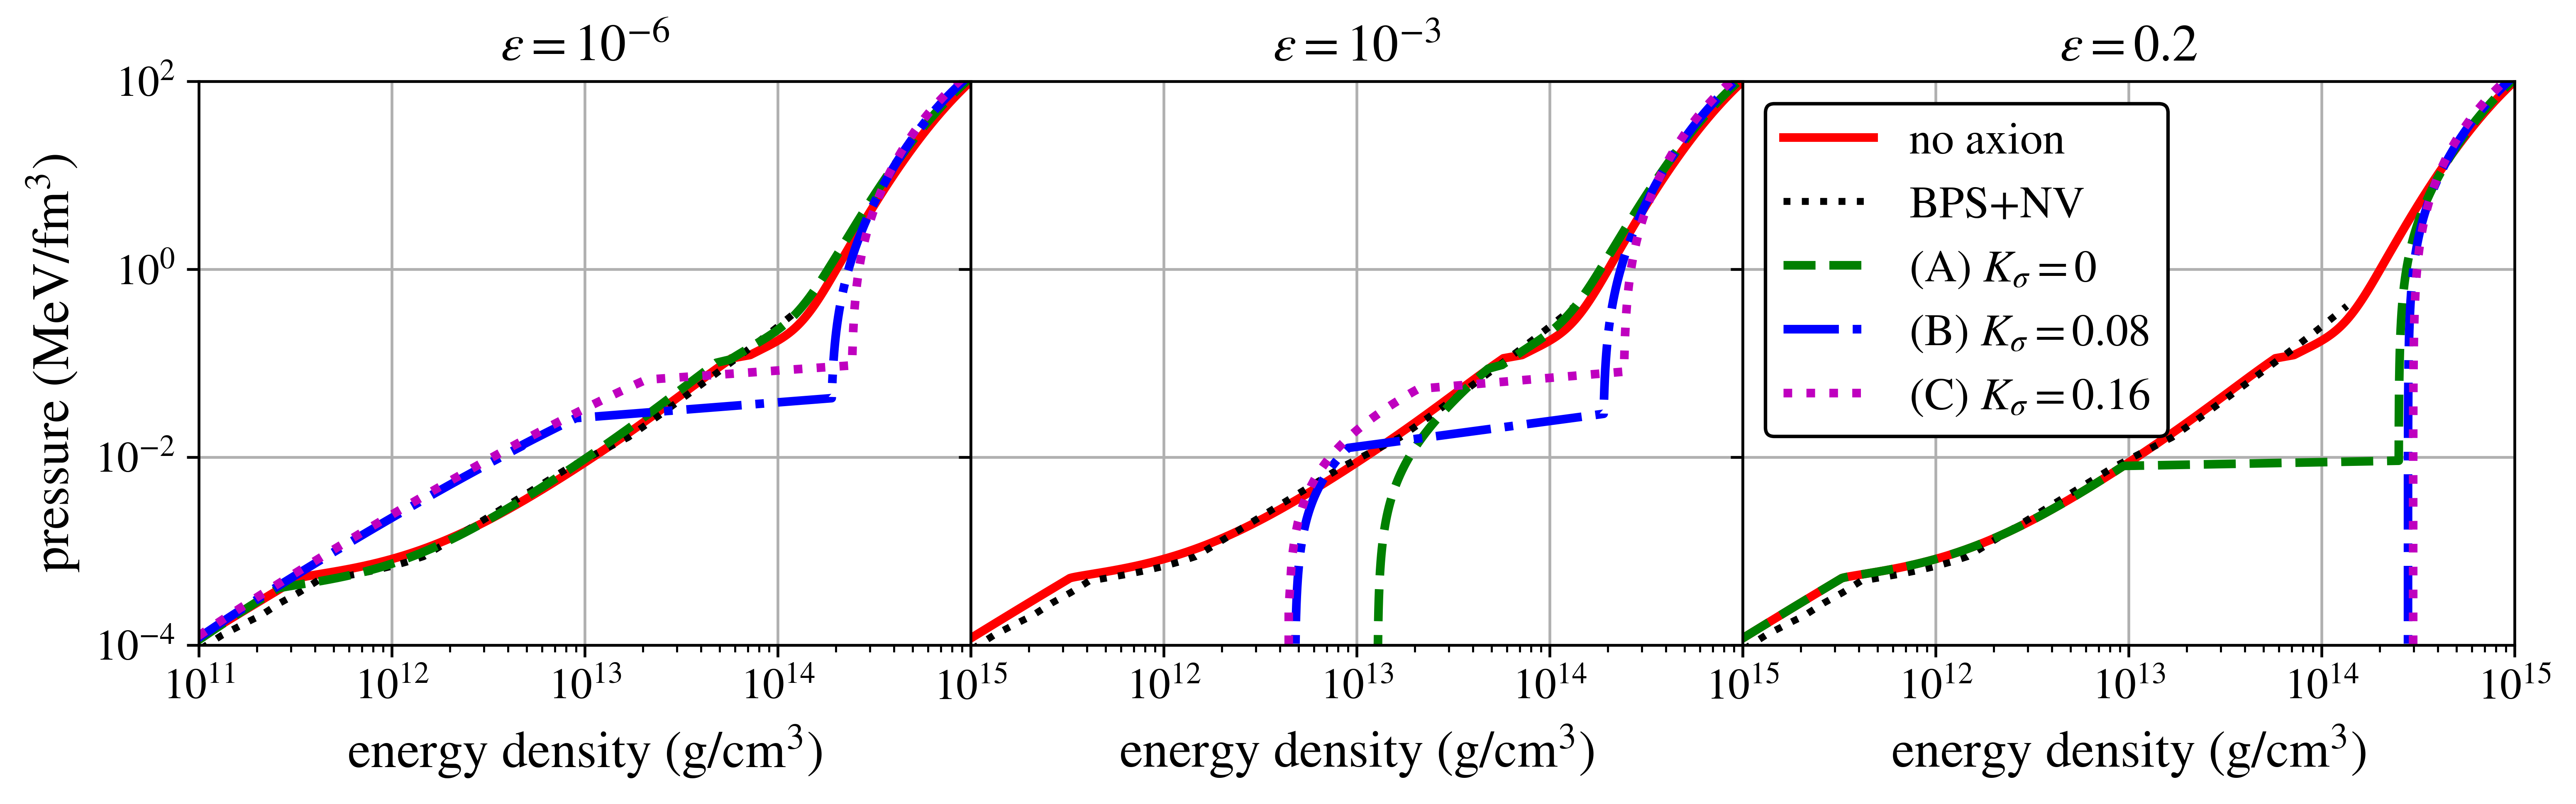

In [32]:
eps_range = [1e-6, 1e-3, 0.2]

fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3))
fig.subplots_adjust(wspace = 0)

p_norm = [elt * 197.3 for elt in p_norm_raw]
ed_norm = [elt * 197.3 * MEVFM3_TO_GCM3 for elt in ed_norm_raw]

for eix, eps in enumerate(eps_range):
    ax_temp = ax[eix]
    shift = eps * F_PION**2 * PION_MASS**2 * (1 - FTHETA_MIN)
    p_ax0_shift = [197.3 * (elt - shift) for elt in p_ax0]
    ed_ax0_shift = [197.3 * MEVFM3_TO_GCM3 * (elt + shift) for elt in ed_ax0]
    p_ax2_shift = [197.3 * (elt - shift) for elt in p_ax2]
    ed_ax2_shift = [197.3 * MEVFM3_TO_GCM3 * (elt + shift) for elt in ed_ax2]
    p_ax4_shift = [197.3 * (elt - shift) for elt in p_ax4]
    ed_ax4_shift = [197.3 * MEVFM3_TO_GCM3 * (elt + shift) for elt in ed_ax4]

    ax_temp.plot(ed_norm, p_norm, 'r-', lw = 2.5)
    ax_temp.plot([elt * 197.3 * MEVFM3_TO_GCM3 for elt in bps_energy_density], [elt * 197.3 for elt in bps_pressure], 'k:', lw = 2)

    p_of_mub_norm = interp1d(mub_norm, p_norm, fill_value='extrapolate')
    ed_of_mub_norm = interp1d(mub_norm, ed_norm, fill_value='extrapolate')
    p_of_mub_ax0 = interp1d(mub_ax0, p_ax0_shift, fill_value='extrapolate')
    ed_of_mub_ax0 = interp1d(mub_ax0, ed_ax0_shift, fill_value='extrapolate')
    p_of_mub_ax2 = interp1d(mub_ax2, p_ax2_shift, fill_value='extrapolate')
    ed_of_mub_ax2 = interp1d(mub_ax2, ed_ax2_shift, fill_value='extrapolate')
    p_of_mub_ax4 = interp1d(mub_ax4, p_ax4_shift, fill_value = 'extrapolate')
    ed_of_mub_ax4 = interp1d(mub_ax4, ed_ax4_shift, fill_value = 'extrapolate')

    if eix == 0:
        ax_temp.plot(ed_ax0_shift, p_ax0_shift, 'g--', ed_ax2_shift, p_ax2_shift, 'b-.', ed_ax4_shift, p_ax4_shift, 'm:', lw = 2.5)
    elif eix == 1:
        #find the chemical potential where there is pressure equality between the two phases (in practice domain wall pressure is negligible at this resolution)
        mub_transition = fsolve(lambda mub: p_of_mub_norm(mub) - p_of_mub_ax0(mub), NEUTRON_MASS)
        ed_ax0_full = [elt for ix, elt in enumerate(ed_norm) if mub_norm[ix] < mub_transition] + [
            ed_of_mub_norm(mub_transition[0]), ed_of_mub_ax0(mub_transition[0])] + [elt for ix, elt in enumerate(ed_ax0_shift) if mub_ax0[ix] > mub_transition]
        p_ax0_full = [elt for ix, elt in enumerate(p_norm) if mub_norm[ix] < mub_transition] + [
            p_of_mub_norm(mub_transition[0]), p_of_mub_ax0(mub_transition[0])] + [elt for ix, elt in enumerate(p_ax0_shift) if mub_ax0[ix] > mub_transition]
        ax_temp.plot(ed_ax0_full, p_ax0_full, 'g--', ed_ax2_shift, p_ax2_shift, 'b-.', ed_ax4_shift, p_ax4_shift, 'm:', lw = 2.5)
    else:
        mub_transition0 = fsolve(lambda mub: p_of_mub_norm(mub) - p_of_mub_ax0(mub), NEUTRON_MASS)
        ed_ax0_full = [elt for ix, elt in enumerate(ed_norm) if mub_norm[ix] < mub_transition0] + [
            elt for ix, elt in enumerate(ed_ax0_shift) if mub_ax0[ix] > mub_transition0]
        p_ax0_full = [elt for ix, elt in enumerate(p_norm) if mub_norm[ix] < mub_transition0] + [
            elt for ix, elt in enumerate(p_ax0_shift) if mub_ax0[ix] > mub_transition0]
        ax_temp.plot(ed_ax0_full, p_ax0_full, 'g--', ed_ax2_shift, p_ax2_shift, 'b-.', ed_ax4_shift, p_ax4_shift, 'm:', lw = 2.5)

    if eix == 2:
        ax_temp.set_title('$\\varepsilon = $' + str(eps), fontsize = 15)
    elif eix == 1:
        ax_temp.set_title('$\\varepsilon = 10^{-3}$', fontsize = 15)
    else:
        ax_temp.set_title('$\\varepsilon = 10^{-6}$', fontsize = 15)
    ax_temp.tick_params(axis = 'both', which = 'major', labelsize = 12.5)
    ax_temp.set_xlabel('energy density (g/cm$^3$)', fontsize = 15)
    
    ax_temp.set_xscale('log')
    ax_temp.set_yscale('log')
    ax_temp.set_xlim([1e11, 1e15])
    ax_temp.grid(alpha = 1)
    if eix > 0:
        ax_temp.set_xticklabels([' ', ' ', '$10^{12}$', '$10^{13}$', '$10^{14}$', '$10^{15}$'])
    
ax[0].set_ylabel('pressure (MeV/fm$^3$)', fontsize = 15)
ax[0].set_ylim([1e-4, 1e2])
ax[2].legend(['no axion', 'BPS+NV', '(A) $K_\sigma = 0$', '(B) $K_\sigma = 0.08$', '(C) $K_\sigma = 0.16$'], fontsize = 13, edgecolor = 'k', framealpha = 1)
    

-1.2620113287731272e-16
-8.261620554339544e-17
-1.22514845490862e-17


<ipython-input-12-6c978a615e5c>:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_temp.set_xticklabels([' ', ' ', '$10^{-4}$', '$10^{-2}$', '$10^0$'])


Text(0, 0.5, 'pressure (MeV/fm$^3$)')

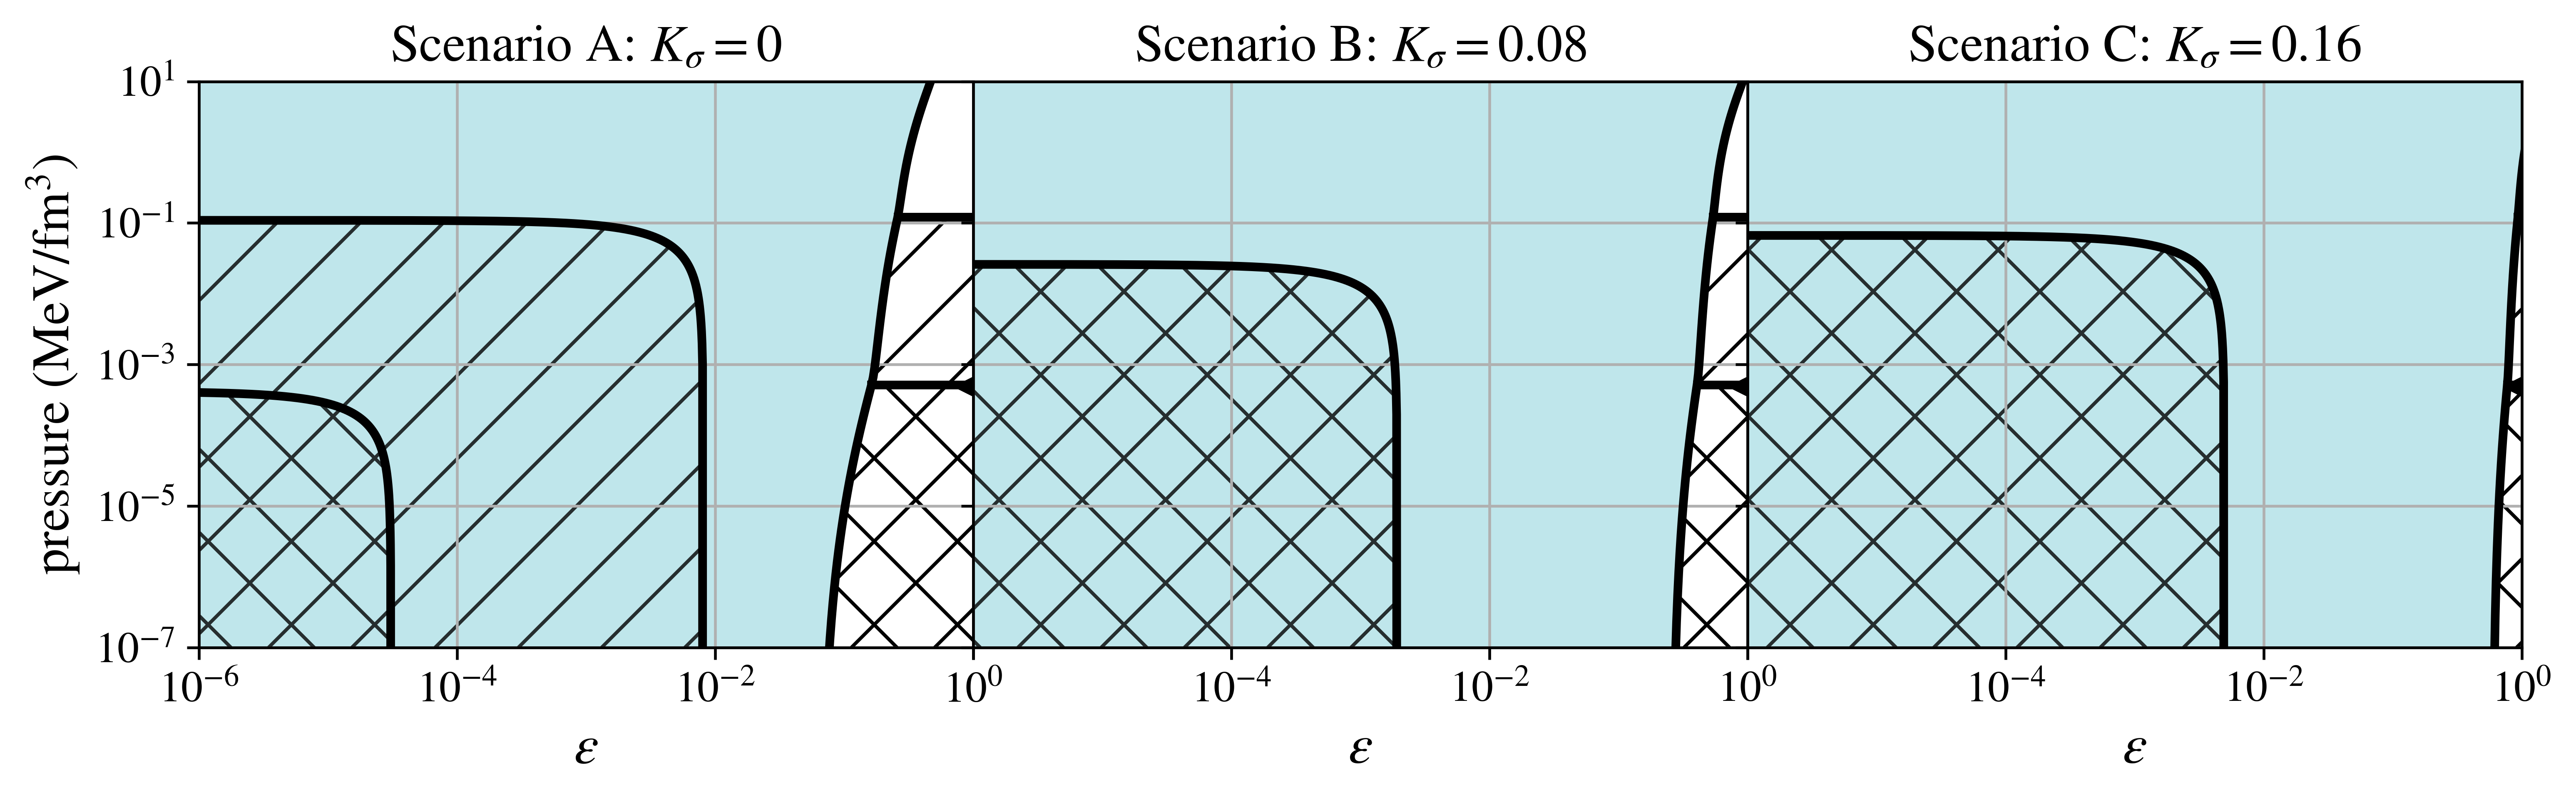

In [12]:
dsig_range = [0, 0.2, 0.47]
#mub just outside the neutron drip phase transition
mub_drip = [-29.46 / 197.3, -35.55 / 197.3, -53.522 / 197.3]
mue_drip_norm = 0.1325
p_drip_norm = 197.3 * mue_drip_norm**4 / (12 * pi**2)
p_drip_bps = 197.3 * 2.469e-6 #bps neutron drip pressure in MeV/fm^3

eps_factor = 197.3 * F_PION**2 * PION_MASS**2 * (1 - FTHETA_MIN)

mub_crust_core = [NUCLEON_MASS - 19.85 / 197.3]
mub_crust_core_norm = NUCLEON_MASS + 10.14 / 197.3
p_crust_core_ax = [197.3 * iufsu_star(50 / 197.3, 1 / 197.3, 0, dsig_range[ix]).eos_data(elt, ftheta_val = FTHETA_MIN)[4] 
                   for ix, elt in enumerate(mub_crust_core)]
p_crust_core_norm = 197.3 * iufsu_star(50 / 197.3, 1 / 197.3, 0, 0).eos_data(mub_crust_core_norm, ftheta_val = 1)[4]

fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12,3))
fig.subplots_adjust(wspace = 0)

p_list = [[elt * 197.3 for elt in p_ax0], [elt * 197.3 for elt in p_ax2], [elt * 197.3 for elt in p_ax4]]
mub_list = [mub_ax0, mub_ax2, mub_ax4]

for ix, dsig in enumerate(dsig_range):
    ax_temp = ax[ix]

    constants = iufsu_star(sig_pin, delta_sigma, 0, dsig, 0, 0)
    p_drip_ax = 197.3 * constants.eos_data_outer_crust_finite_size(NUCLEON_MASS + mub_drip[ix], ftheta_val = FTHETA_MIN, surf_tension = st)[4]
    
    p_of_mub_norm = interp1d(mub_norm, p_norm, fill_value = 'extrapolate')
    p_of_mub = interp1d(mub_list[ix], p_list[ix], fill_value = 'extrapolate')
    eps_transition_min = (p_of_mub(mub_norm[0]) - p_norm[0]) / eps_factor
    eps_transition_max = (p_list[ix][-1] - p_of_mub_norm(mub_list[ix][-1])) / eps_factor

    eps_transition = logspace(log10(eps_transition_min), log10(eps_transition_max), 100)
    p_transition = []

    for eps in eps_transition:
        shift = eps * eps_factor
        mub_temp = fsolve(lambda mub: p_of_mub(mub) - shift - p_of_mub_norm(mub), NUCLEON_MASS)[0]
        p_transition.append(p_of_mub_norm(mub_temp))

    eps_of_p_transition = interp1d(p_transition, eps_transition, fill_value = 'extrapolate')
    p_of_eps_transition = interp1d(eps_transition, p_transition, fill_value = 'extrapolate')

    outer_hatch = 'x'
    inner_hatch = '/'
    ax_color = 'powderblue'
    ax_alpha = 0.8
    hatch_weight = 0.5

    #draw coexistence line of axion and normal phase
    ax_temp.plot(eps_transition, p_transition, 'k-', lw = 2.5)
    #draw crust boundaries in normal phase
    ax_temp.plot([eps_of_p_transition(p_crust_core_norm), 1], [p_crust_core_norm, p_crust_core_norm], 'k-', 
                 [eps_of_p_transition(p_drip_norm), 1], [p_drip_norm, p_drip_norm], 'k-', lw = 2.5)
    #make hatches in normal phase outer crust
    ax_temp.fill([elt for ix, elt in enumerate(eps_transition) if p_transition[ix] < p_drip_norm] 
                 + [eps_of_p_transition(p_drip_norm), 1, 1], [elt for elt in p_transition if elt < p_drip_norm] 
                 + [p_drip_norm, p_drip_norm, 0], hatch = outer_hatch, facecolor = 'white', edgecolor = 'black',
                 lw = hatch_weight)
    #make hatches in normal phase inner crust
    ax_temp.fill([elt for ix, elt in enumerate(eps_transition) if p_drip_norm < p_transition[ix] < p_crust_core_norm] 
                 + [eps_of_p_transition(p_crust_core_norm), 1, 1, eps_of_p_transition(p_drip_norm)],
                 [elt for elt in p_transition if p_drip_norm < elt < p_crust_core_norm] 
                 + [p_crust_core_norm, p_crust_core_norm, p_drip_norm, p_drip_norm], hatch = inner_hatch, 
                 facecolor = 'white', edgecolor = 'black', lw = hatch_weight)
    #draw crust boundaries in axion phase
    if ix < 1:
        if p_crust_core_ax[ix] / eps_factor < eps_transition_min:
            eps_ax_inner = logspace(-6, log10(p_crust_core_ax[ix] / eps_factor), 1000)
        else:
            eps_max_inner = fsolve(lambda eps: p_crust_core_ax[ix] - eps * eps_factor - p_of_eps_transition(eps), eps_transition_min)[0]
            eps_ax_inner = logspace(-6, log10(eps_max_inner), 1000)
        p_ax_inner = [p_crust_core_ax[ix] - elt * eps_factor for elt in eps_ax_inner]
        ax_temp.plot(eps_ax_inner, p_ax_inner, 'k-', lw = 2.5)
    if p_drip_ax / eps_factor < eps_transition_min:
        eps_ax_outer = logspace(-6, log10(p_drip_ax / eps_factor), 1000)
    else:
        eps_max_outer = fsolve(lambda eps: p_drip_ax[ix] - eps * eps_factor - p_of_eps_transition(eps), eps_transition_min)[0]
        eps_ax_outer = logspace(-6, log10(eps_max_outer), 1000)
    p_ax_outer = [p_drip_ax - elt * eps_factor for elt in eps_ax_outer]
    ax_temp.plot(eps_ax_outer, p_ax_outer, 'k-', lw = 2.5)
    #make hatches in ax phase outer crust
    ax_temp.fill(list(eps_ax_outer) + [1e-6], p_ax_outer + [0], hatch = outer_hatch, facecolor = ax_color, 
                 edgecolor = 'black', alpha = ax_alpha, lw = hatch_weight)
    #make hatches in ax phase inner crust
    if ix < 1:
        ax_temp.fill(list(eps_ax_inner) + list(eps_ax_outer)[::-1], p_ax_inner + p_ax_outer[::-1],
            facecolor = ax_color, edgecolor = 'black', alpha = ax_alpha, lw = hatch_weight, hatch = inner_hatch)
    #shade axion core
    if ix < 1:
        ax_temp.fill(list(eps_ax_inner) + list(eps_transition) + [1e-6], p_ax_inner + p_transition + [10],
                     facecolor = ax_color, alpha = ax_alpha)
    else:
        ax_temp.fill(list(eps_ax_outer) + list(eps_transition) + [1e-6], p_ax_outer + p_transition + [10],
                     facecolor = ax_color, alpha = ax_alpha)
    #add mark to show bps neutron drip
    ax_temp.scatter([0.9], [p_drip_bps], marker = '<', zorder = 10, c = 'k')

    ax_temp.set_xscale('log')
    ax_temp.set_xlim([1e-6, 1])
    ax_temp.tick_params(axis = 'both', which = 'major', labelsize = 12.5)
    ax_temp.set_xlabel('$\\varepsilon$', fontsize = 16)
    if ix > 0:
        ax_temp.set_xticklabels([' ', ' ', '$10^{-4}$', '$10^{-2}$', '$10^0$'])
    ax_temp.grid(alpha = 1)

ax[0].set_title('Scenario A: $K_\sigma = 0$', fontsize = 15)
ax[1].set_title('Scenario B: $K_\sigma = 0.08$', fontsize = 15)
ax[2].set_title('Scenario C: $K_\sigma = 0.16$', fontsize = 15)

ax[0].set_yscale('log')
ax[0].set_ylim([1e-7, 10])
ax[0].set_ylabel('pressure (MeV/fm$^3$)', fontsize = 15)

The code below will find mass and radius for a given $\varepsilon$.  Some $\varepsilon$ may require changing the range of cp_space in order to get the whole curve you want

If you want to calculate a lot of stars, this is highly parallelizable with multiprocessing.Pool()

In [20]:
# tovsolver() can get finicky when there's a jump in pressure that it doesn't know what to do with so making the pressure be properly equal helps
p2_fix = p_ax2[:2000] + [p_ax2[1999]] + p_ax2[2000:]
ed2_fix = ed_ax2[:2000] + [ed_ax2[2000]] + ed_ax2[2000:]
p4_fix = p_ax4[:2000] + [p_ax4[1999]] + p_ax4[2000:]
ed4_fix = ed_ax4[:2000] + [ed_ax4[2000]] + ed_ax4[2000:]

#range of central pressures to calculate stars for
cp_space = logspace(log10(0.05 * 0.1973), log10(1.5 * 0.1973), 20)

#example eps, set this to whatever you want
eps_temp = 0.2

mnorm = []
rnorm = []
m0 = []
r0 = []
m2 = []
r2 = []
m4 = []
r4 = []

#modify the eos to include eps since it was set to zero when the eos was first calculated 
#also note that tov_solver() wants energy density and pressure in GeV/fm^3, not fm^-4
pnorm_temp = [elt * 0.1973 for elt in p_norm_raw]
ednorm_temp = [elt * 0.1973 for elt in ed_norm_raw]

shift = eps_temp * F_PION**2 * PION_MASS**2 * (1 - FTHETA_MIN)
p0_temp = [(elt - shift) * 0.1973 for elt in p_ax0]
ed0_temp = [(elt + shift) * 0.1973 for elt in ed_ax0]

p2_temp = [(elt - shift) * 0.1973 for elt in p_ax2]
ed2_temp = [(elt + shift) * 0.1973 for elt in ed_ax2]

p4_temp = [(elt - shift) * 0.1973 for elt in p_ax4]
ed4_temp = [(elt + shift) * 0.1973 for elt in ed_ax4]

p_of_mub_norm = interp1d(mub_norm, pnorm_temp, fill_value='extrapolate')
ed_of_mub_norm = interp1d(mub_norm, ednorm_temp, fill_value='extrapolate')
p_of_mub_ax = interp1d(mub_ax0, p0_temp, fill_value='extrapolate')
ed_of_mub_ax = interp1d(mub_ax0, ed0_temp, fill_value='extrapolate')

#find the transition pressure for Ksig = 0, for this epsilon the whole star is axion condensed for larger Ksig considered
#as before, adding a point so that the pressure jump is perfectly flat can help stability of the solver
mub_transition = fsolve(lambda mub: p_of_mub_norm(mub) - p_of_mub_ax(mub), NEUTRON_MASS)
ed0_comb = [elt for ix, elt in enumerate(ed_norm_raw) if mub_norm[ix] < mub_transition] + [
    ed_of_mub_norm(mub_transition[0]), ed_of_mub_ax(mub_transition[0])] + [
    elt for ix, elt in enumerate(ed0_temp) if mub_ax0[ix] > mub_transition]
p0_comb = [elt for ix, elt in enumerate(p_norm_raw) if mub_norm[ix] < mub_transition] + [
    p_of_mub_norm(mub_transition[0]), p_of_mub_ax(mub_transition[0])] + [
    elt for ix, elt in enumerate(p0_temp) if mub_ax0[ix] > mub_transition]
#including singularities is generally not necessary when just finding masses and radii but the singularity handler does fix certain problems when finding tidal deformability
#this singularity is the location of the phase transition
sing0 = [p_of_mub_norm(mub_transition[0]) * 0.1973]

for cp in cp_space:
    #give tov_solver() the optional argument num_steps to determine how many grid points you want the final answer to have
    #default integration size and integration step is typically fine for all NS configurations, but if you want to mess with it
    #the optional argument len_r_eval tells how far out to integrate (in units of solar Schwarzschidl radii ~ 2.95 km)
    #and eval stepss tells how many steps for the solver to use, too few can give a jiggy M-R curve because finding zero pressure is touchy
    tov_results_temp = tov_solver(cp, pnorm_temp, ednorm_temp)
    mnorm.append(tov_results_temp.contained_mass[-1])
    rnorm.append(tov_results_temp.radius_range[-1])
    
    tov_results_temp = tov_solver(cp, p0_comb, ed0_comb)
    m0.append(tov_results_temp.contained_mass[-1])
    r0.append(tov_results_temp.radius_range[-1])

    tov_results_temp = tov_solver(cp, p2_temp, ed2_temp)
    m2.append(tov_results_temp.contained_mass[-1])
    r2.append(tov_results_temp.radius_range[-1])

    tov_results_temp = tov_solver(cp, p4_temp, ed4_temp)
    m4.append(tov_results_temp.contained_mass[-1])
    r4.append(tov_results_temp.radius_range[-1])

(8.0, 14.0)

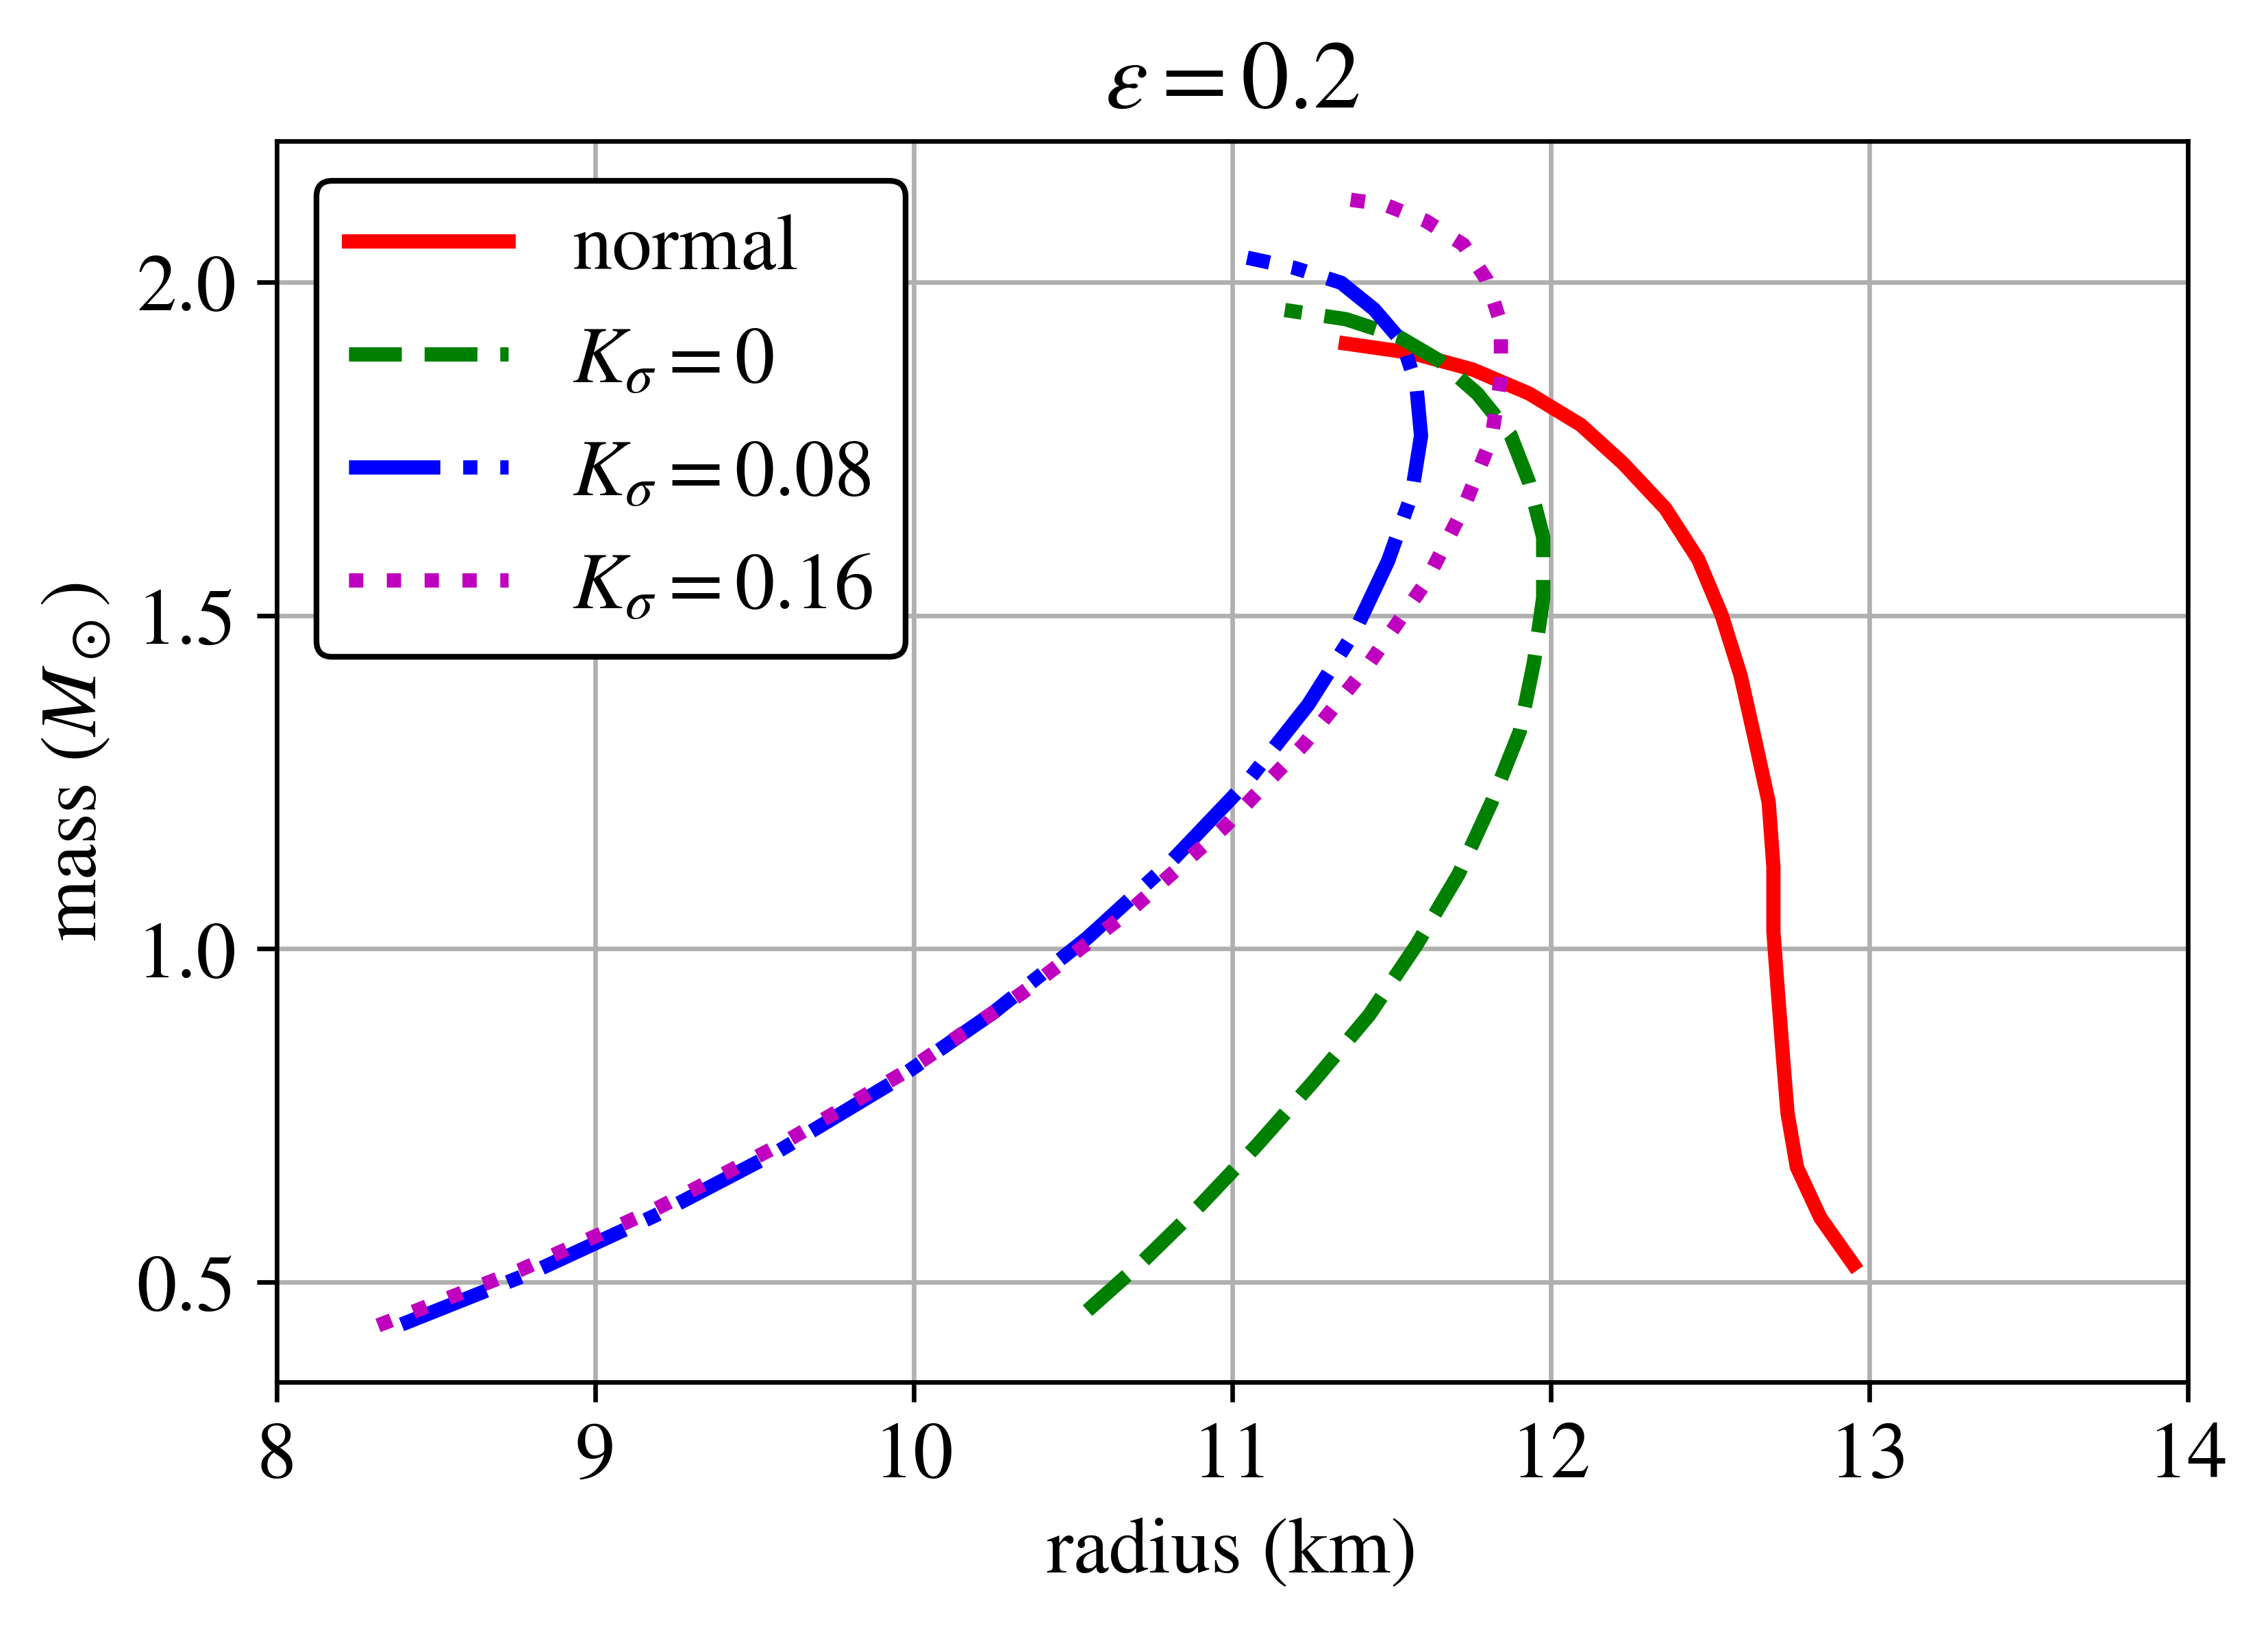

In [22]:
plt.plot(rnorm, mnorm, 'r-', r0, m0, 'g--', r2, m2, 'b-.', r4, m4, 'm:')
plt.xlabel('radius (km)')
plt.ylabel('mass ($M_\odot$)')
plt.legend(['normal', '$K_\sigma = 0$', '$K_\sigma = 0.08$', '$K_\sigma = 0.16$'], edgecolor = 'k', framealpha = 1)
plt.grid(True)
plt.title('$\\varepsilon = 0.2$')
plt.xlim([8, 14])